# Train YOLOv5 on a custom dataset

<font size="1.5pt">OVHcloud  disclaims to the fullest extent authorized by law all warranties, whether express or implied, including any implied warranties of title, non-infringement, quiet enjoyment, integration, merchantability or fitness for a particular purpose regarding the use of the database ImageNet in the context of this notebook. The user shall fully comply with the terms of use that appears on the database website (https://cocodataset.org/).</font>

## Introduction

The purpose of this tutorial is to show how it is possible to train YOLOv5 to recognise objects. It is based on the YOLOv5 repository by Ultralytics (https://github.com/ultralytics/yolov5). 

To do this, the YOLOv5m model is trained on the COCO dataset.This notebook shows training on your own custom objects. 

**But what is the COCO dataset ?**

COCO is a large-scale object detection, segmentation, and also captioning dataset. COCO has several features:

- Object segmentation
- Recognition in context
- Superpixel stuff segmentation
- 330K images
- 1.5 million object instances
- 80 object categories
- 91 stuff categories
- 5 captions per image
- 250,000 people with keypoints

## Code

The different steps are as follow :

- Install YOLOv5 dependencies
- Download the COCO dataset
- Define YOLOv5 model
- Install packages for running
- Run YOLOv5 training
- Evaluate YOLOv5 performance on COCO dataset
- Graphs and functions explanation
- Visualize training data with labels
- Run YOLOv5 inference on test images

### Install YOLOv5 dependencies

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 6782, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 6782 (delta 49), reused 53 (delta 27), pack-reused 6696
Receiving objects: 100% (6782/6782), 8.74 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (4656/4656), done.


In [2]:
# YOLOv5 path
%cd yolov5

/workspace/notebook_yolov5_coco_final/yolov5


In [ ]:
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

In [ ]:
# install dependencies as necessary
!pip install -r requirements.txt

In [37]:
import torch

# to display images
from IPython.display import Image, clear_output

# to download models
from utils.google_utils import gdrive_download 

In [6]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.1 _CudaDeviceProperties(name='Tesla V100S-PCIE-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)


### Download the COCO dataset

We can download our dataset COCO from Roboflow (https://public.roboflow.com/object-detection/microsoft-coco-subset/2). The "YOLOv5 PyTorch" format is used.

In [ ]:
# copy and paste the code extract
%cd /workspace/notebook_yolov5_coco_final/
!curl -L "https://public.roboflow.com/ds/IGiAtRcab0?key=teTb0bdAo3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [12]:
# the yaml file is writen by Roboflow and contains informations about our data 
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 80
names: ['aeroplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'cow', 'cup', 'diningtable', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorbike', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'pottedplant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'sofa', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tvmonitor', 'umbrella', 'vase', 'wine glass', 'zebra']

### Define YOLOv5 model

The chosen model is: YOLOv5m

In [13]:
# define number of classes based on data.yaml (here we got 80)
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [14]:
# model configuration used for the tutorial: yolov5m
%cat /workspace/notebook_yolov5_coco_final/yolov5/models/yolov5m.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [15]:
# customize iPython writefile
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [16]:
%%writetemplate /workspace/notebook_yolov5_coco_final/yolov5/models/custom_yolov5m.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

### Install packages for running

In [ ]:
!pip install --upgrade pip

In [ ]:
!pip install opencv-python

In [ ]:
!pip install opencv-python--headless

In [ ]:
conda install -c conda-forge pycocotools

In [ ]:
conda install -c conda-forge/label/qcc7 pycocotools

In [ ]:
conda install -c conda-forge/label/cf201901 pycocotools

In [ ]:
conda install -c conda-forge/label/cf202003 pycocotools

### Run YOLOv5 training

**Parameters definitions:**

- <font color='red'>img</font>: refers to the input images size.
- <font color='red'>batch</font>: refers to the batch size (number of training examples utilized in one iteration).
- <font color='red'>epochs</font>: refers to the number of training epochs. An epoch corresponds to one cycle through the full training dataset.
- <font color='red'>data</font>: refers to the path to the yaml file.
- <font color='red'>cfg</font>: define the model configuration.

In [ ]:
# train yolov5m on custom data for 100 epochs
# time its performance
%time
%cd /workspace/notebook_yolov5_coco_final/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5m.yaml --weights '' --name yolov5m_results  --cache

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
/workspace/notebook_yolov5_coco_final/yolov5
github: skipping check (Docker image)
YOLOv5 v4.0-126-g886f1c0 torch 1.8.1 CUDA:0 (Tesla V100S-PCIE-32GB, 32510.5MB)
                                     CUDA:1 (Tesla V100S-PCIE-32GB, 32510.5MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5m.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5m_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5m_results', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip insta

Here we have an example of training on the first eight epochs. The first seven have been completed and the eighth is underway.

### Evaluate YOLOv5 performance on COCO dataset

Training losses and performance metrics are saved to Tensorboard and also to a logfile named this yolov5m_results. The results file is plotted as a png image after training.

- **Dynamic display:**

To use the dynamic display with tensorboard, you have to start Tensorboard and launch it just after having started the training.

Logs will be saved in the folder named "runs".

In [35]:
!tensorboard --logdir=runs --bind_all

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.5.0 at http://job-aaddcc2f-126a-4ebe-8a97-66f25b2d48b0:6008/ (Press CTRL+C to quit)
^C


- **Static display:**

If you wand to display your graphs statically, use the next code.

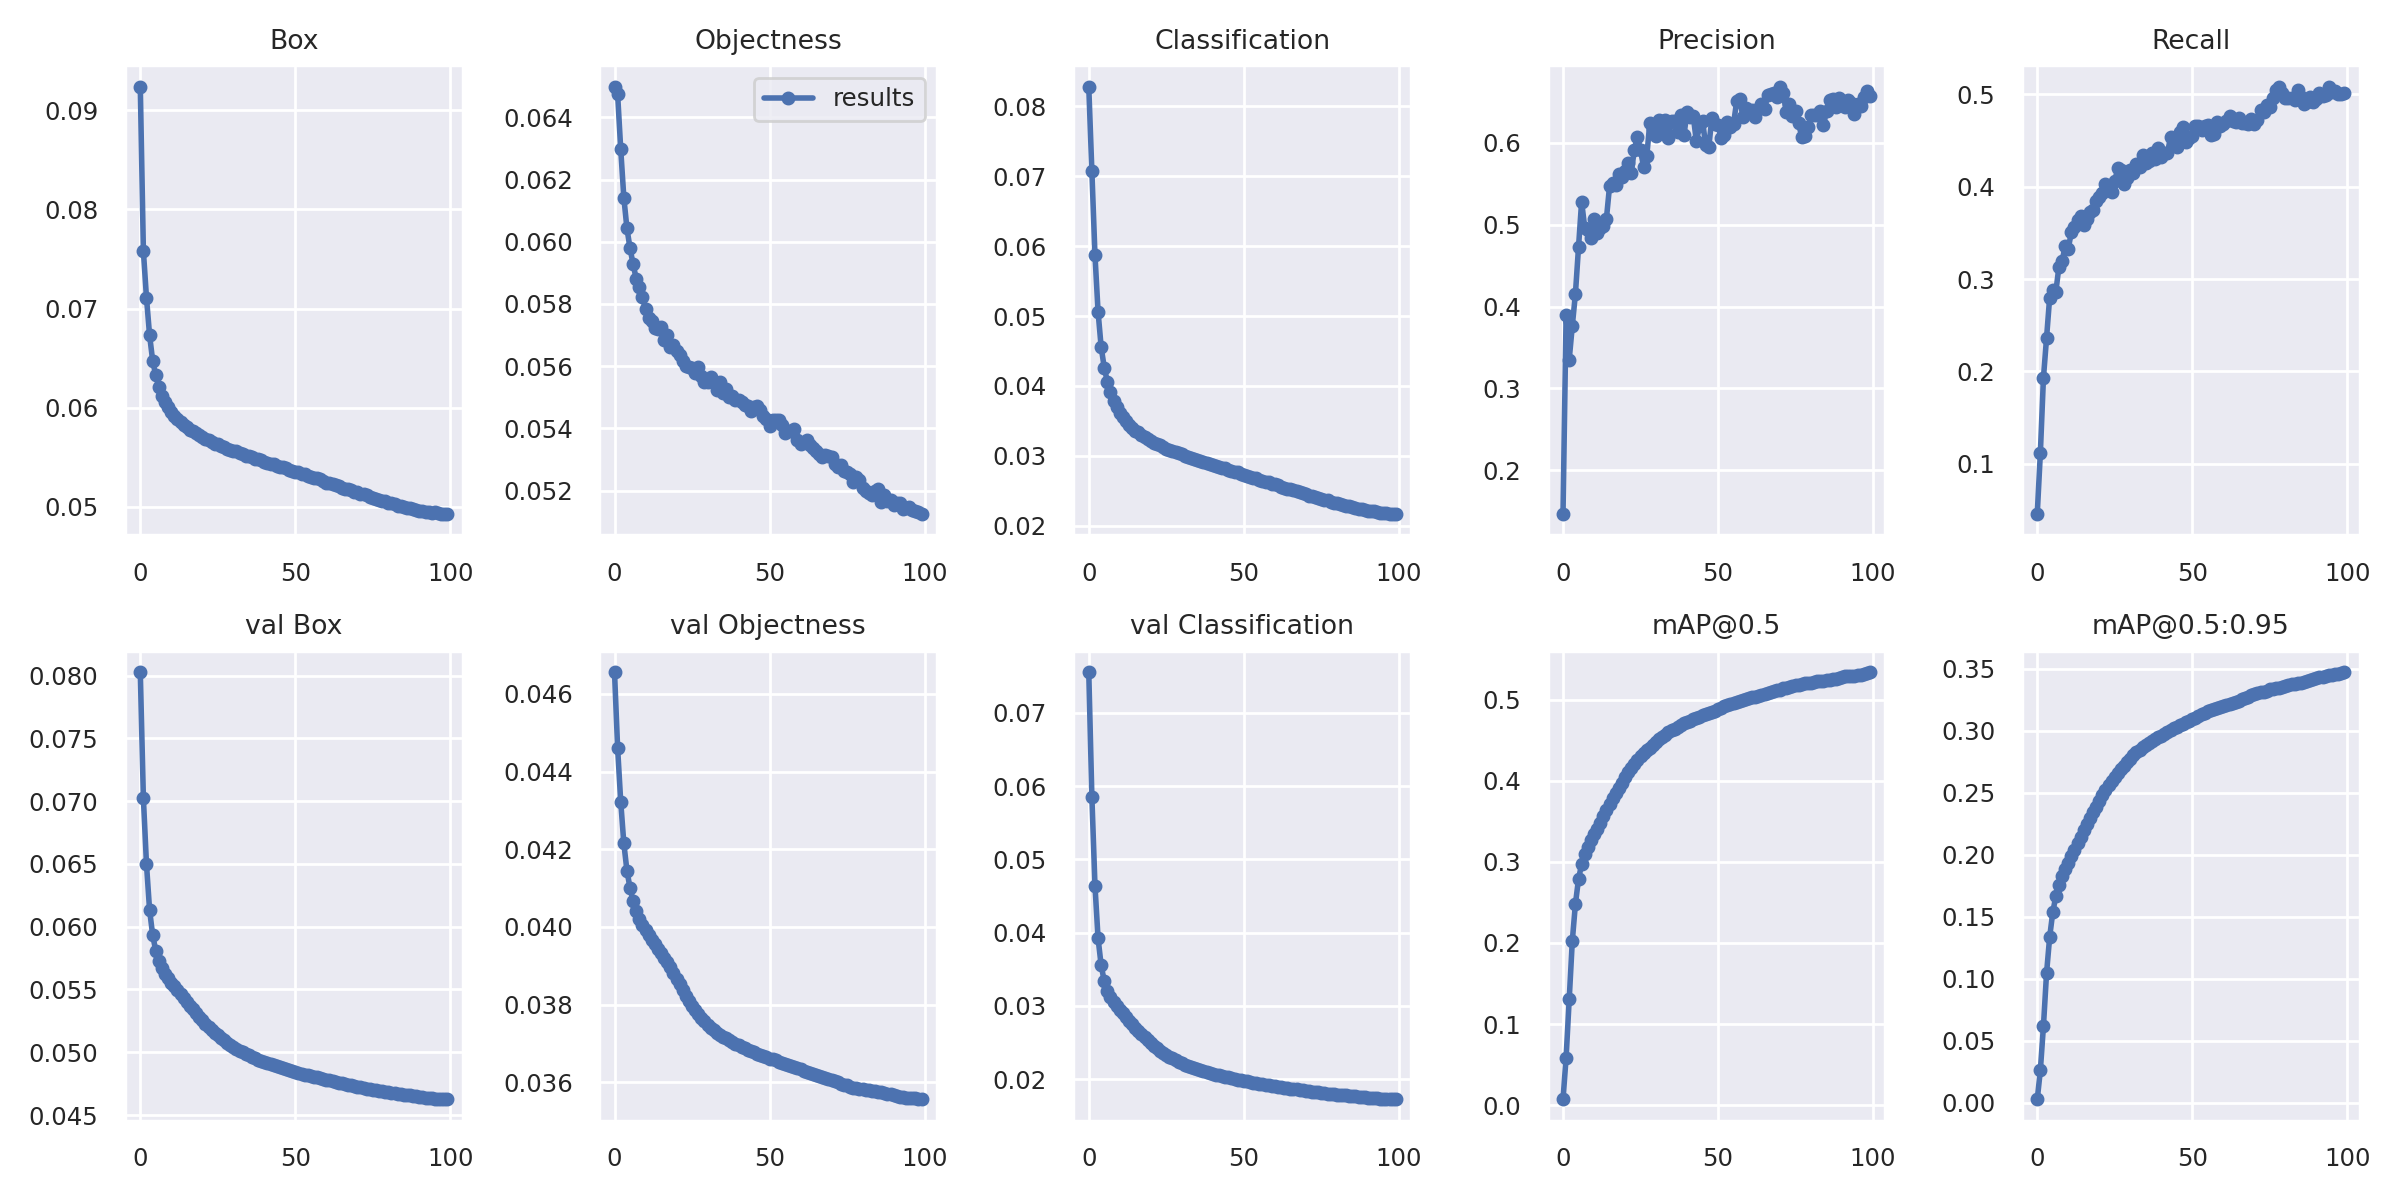

In [38]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/workspace/notebook_yolov5_coco_final/yolov5/runs/train/yolov5m_results/results.png', width=1000)  # view results.png

### Graphs and functions explanation

**Loss functions:**

*For the training set:*
- <font color='red'>Box</font>: loss due to a box prediction not exactly covering an object.
- <font color='red'>Objectness</font>: loss due to a wrong box-object IoU<font color='red'>*</font> prediction.
- <font color='red'>Classification</font>: loss due to deviations from predicting ‘1’ for the correct classes and ‘0’ for all the other classes for the object in that box.

*For the valid set (the same loss functions as for the training data):*
- <font color='red'>val Box</font>
- <font color='red'>val Objectness</font>
- <font color='red'>val Classification</font>


**Precision & Recall:**

- <font color='deepskyblue'>Precision</font>: measures how accurate are the predictions. It is the percentage of your correct predictions.
- <font color='orange'>Recall</font>: measures how good it finds all the positives.

*How to calculate Precision and Recall ?*

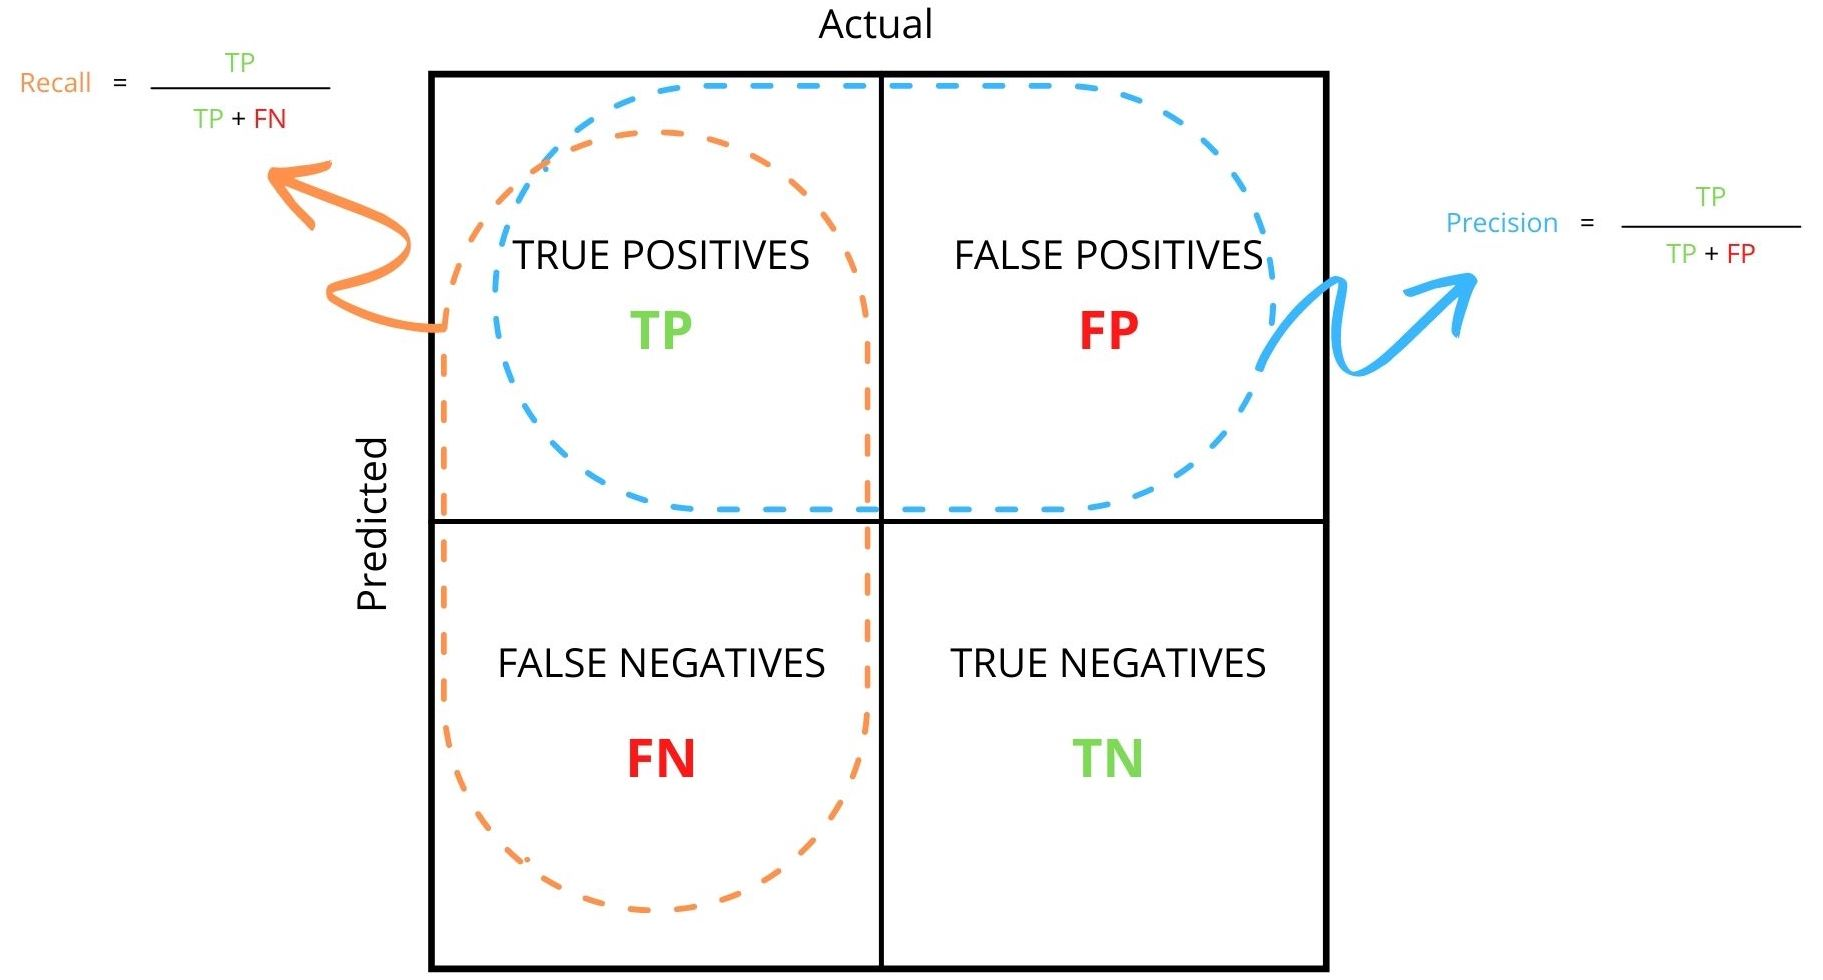

**Accuracy functions:**

mAP (mean Average Precision) compares the ground-truth bounding box to the detected box and returns a score. The higher the score, the more accurate the model is in its detections.

- <font color='green'>mAP@ 0.5</font>：when IoU is set to 0.5, the AP<font color='red'>* *</font> of all pictures of each category is calculated, and then all categories are averaged : mAP.
- <font color='green'>mAP@ 0.5:0.95</font>：represents the average mAP at different IoU thresholds (from 0.5 to 0.95 in steps of 0.05).

<font color='red'>*</font>**IoU (Intersection over Union)** = measures the overlap between two boundaries. It is used to measure how much the predicted boundary overlaps with the ground truth.

*How to calculate IoU ?*

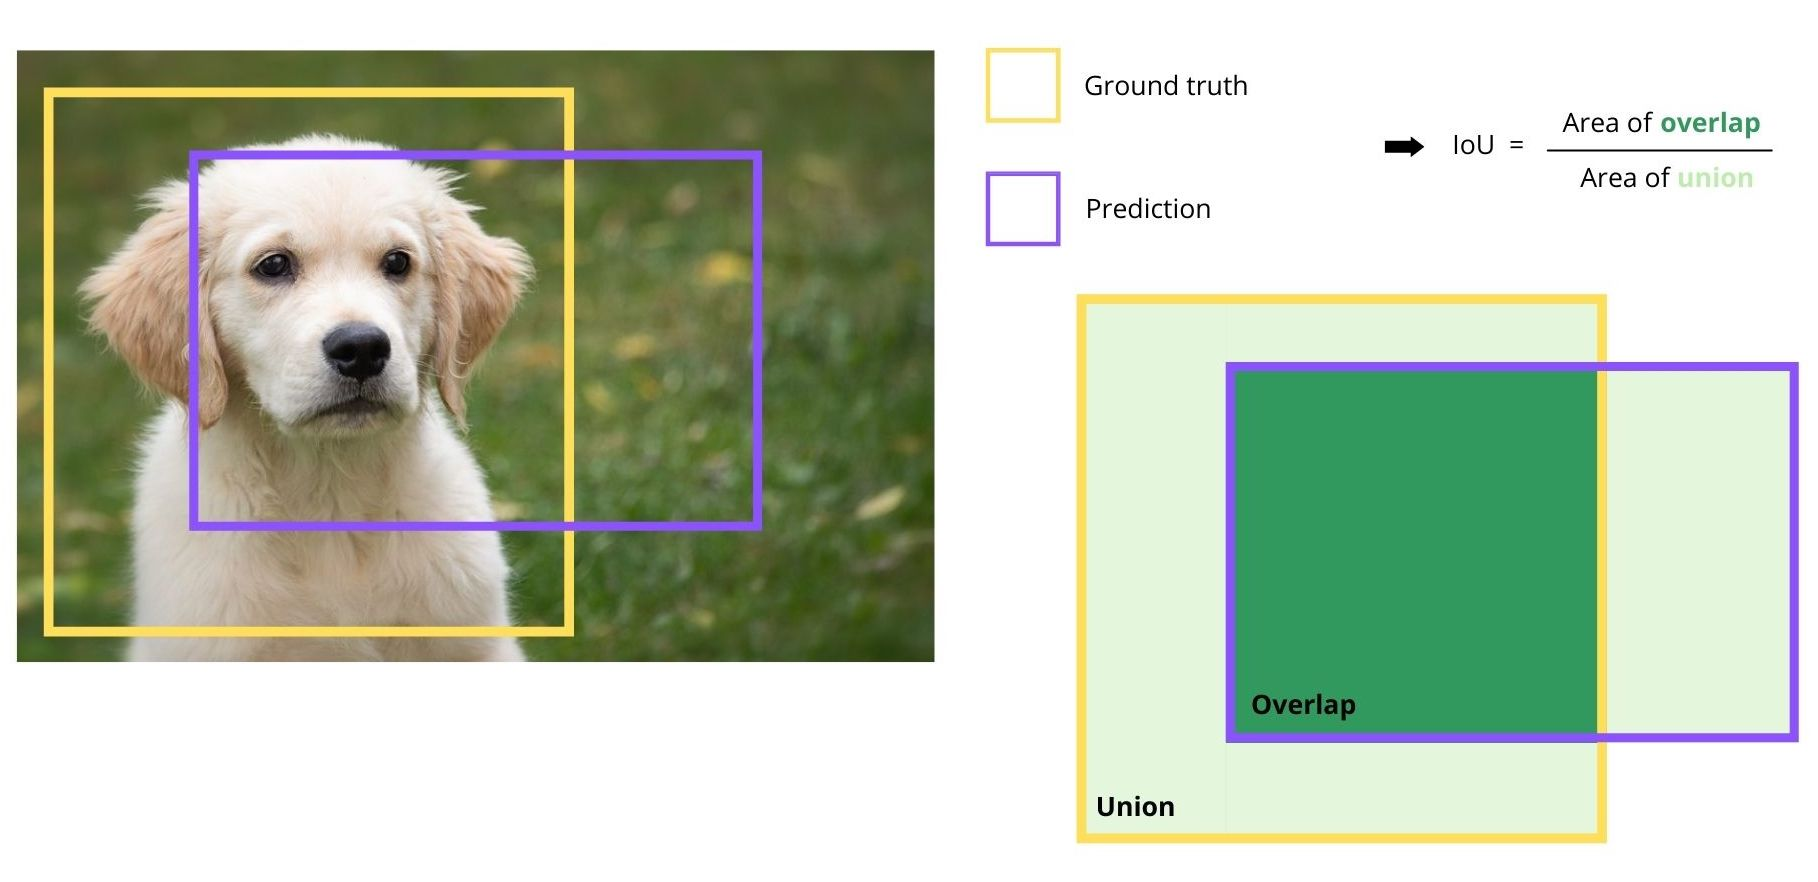

<font color='red'>* *</font>**AP (Average precision)** = popular metric in measuring the accuracy of object detectors. It computes the average precision value for recall value over 0 to 1.

### Visualize training data with labels

Truth from the field of training data:

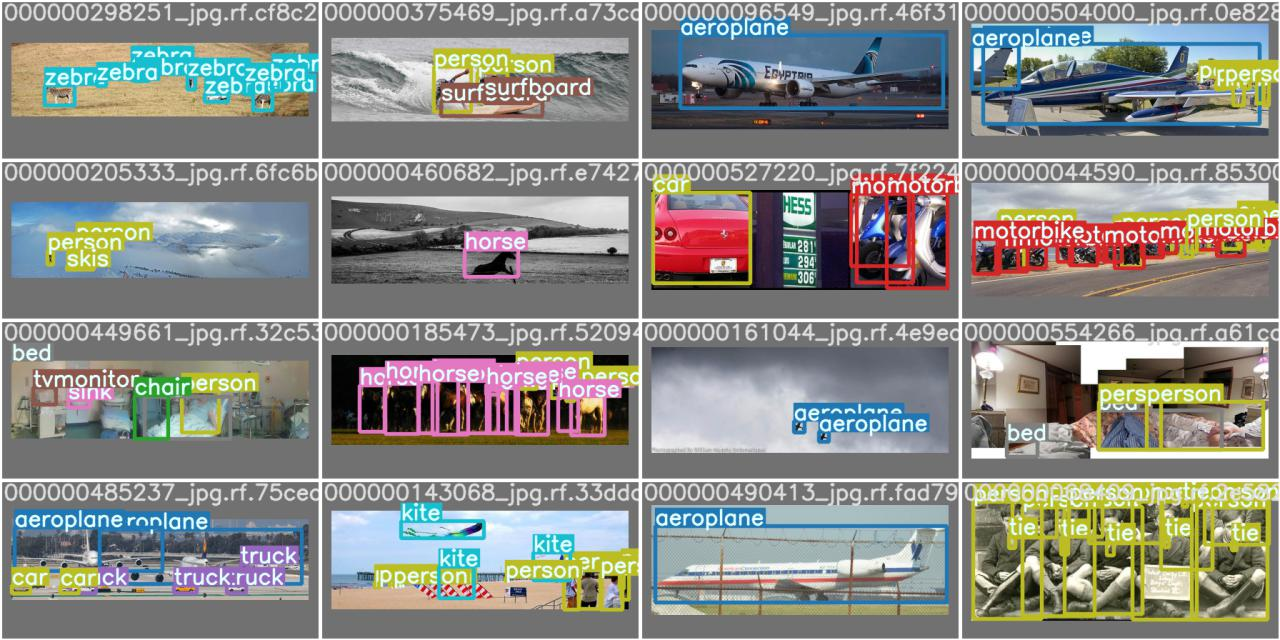

In [39]:
Image(filename='/workspace/notebook_yolov5_coco_final/yolov5/runs/train/yolov5m_results/test_batch0_labels.jpg', width=600)

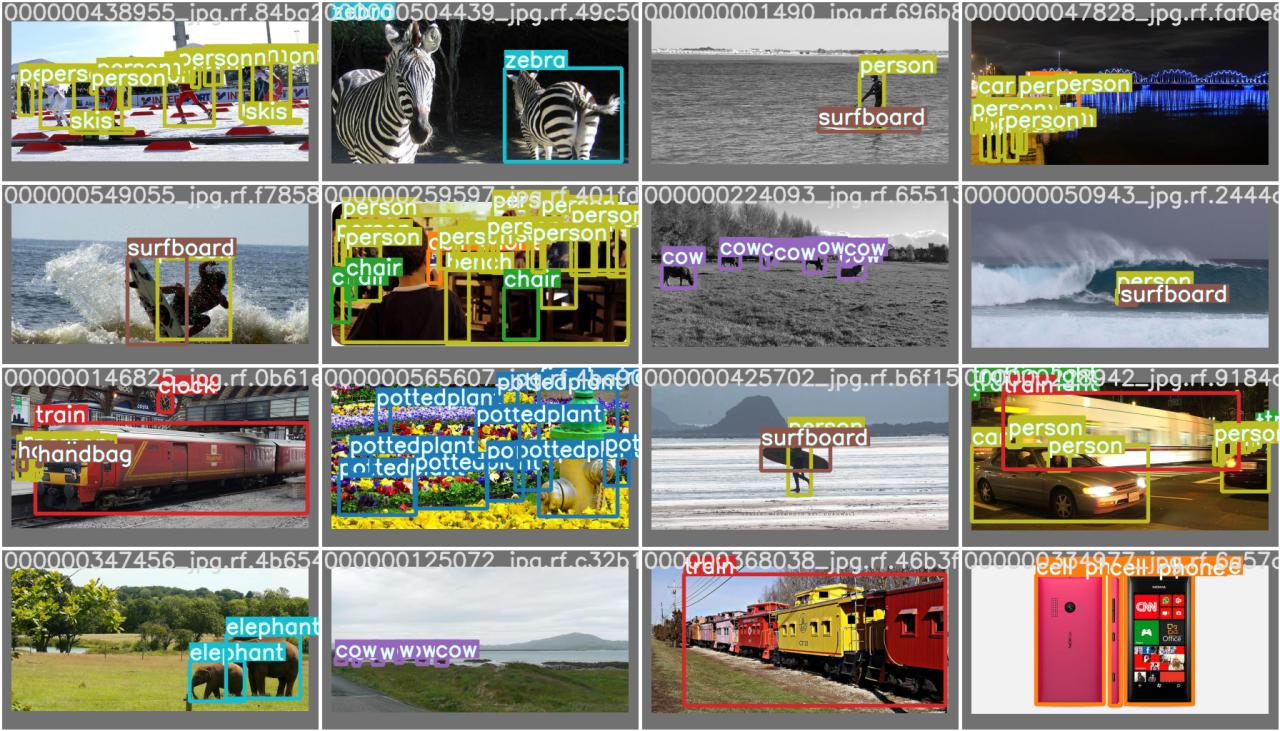

In [40]:
Image(filename='/workspace/notebook_yolov5_coco_final/yolov5/runs/train/yolov5m_results/test_batch1_labels.jpg', width=600)

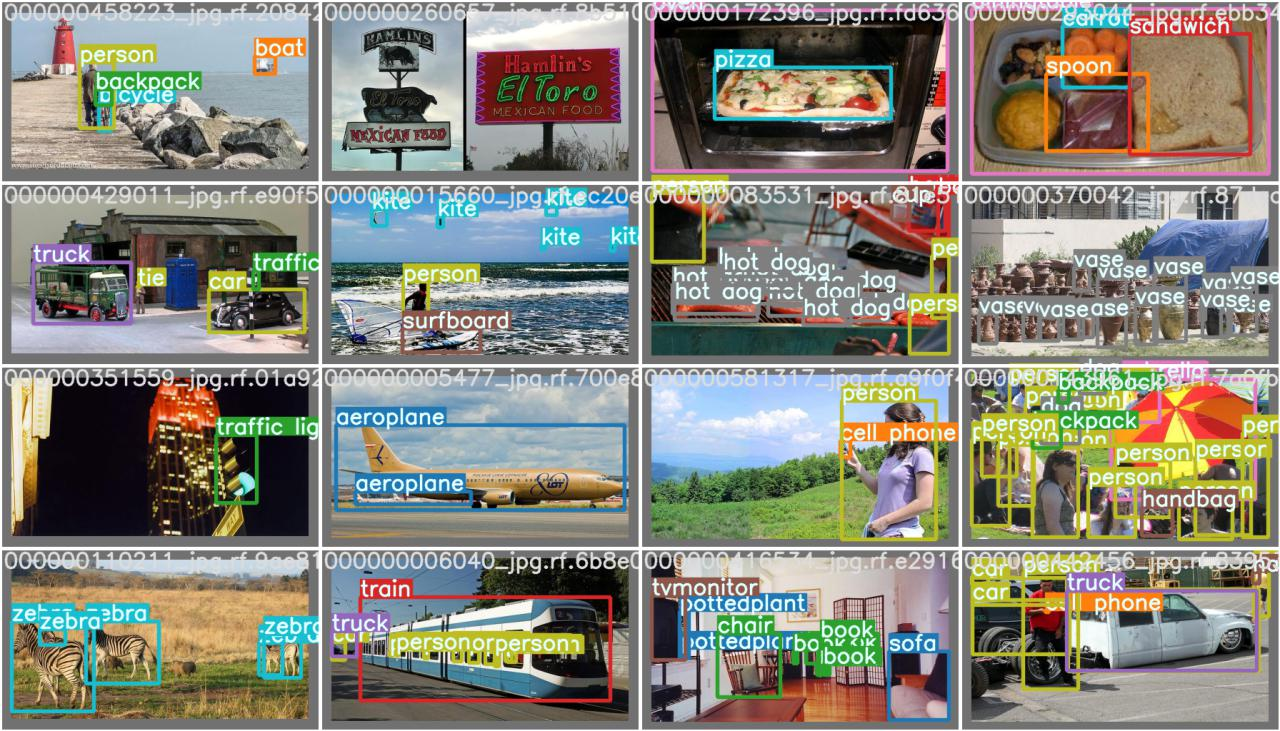

In [41]:
Image(filename='/workspace/notebook_yolov5_coco_final/yolov5/runs/train/yolov5m_results/test_batch2_labels.jpg', width=600)

Truth from the field of increased training data:

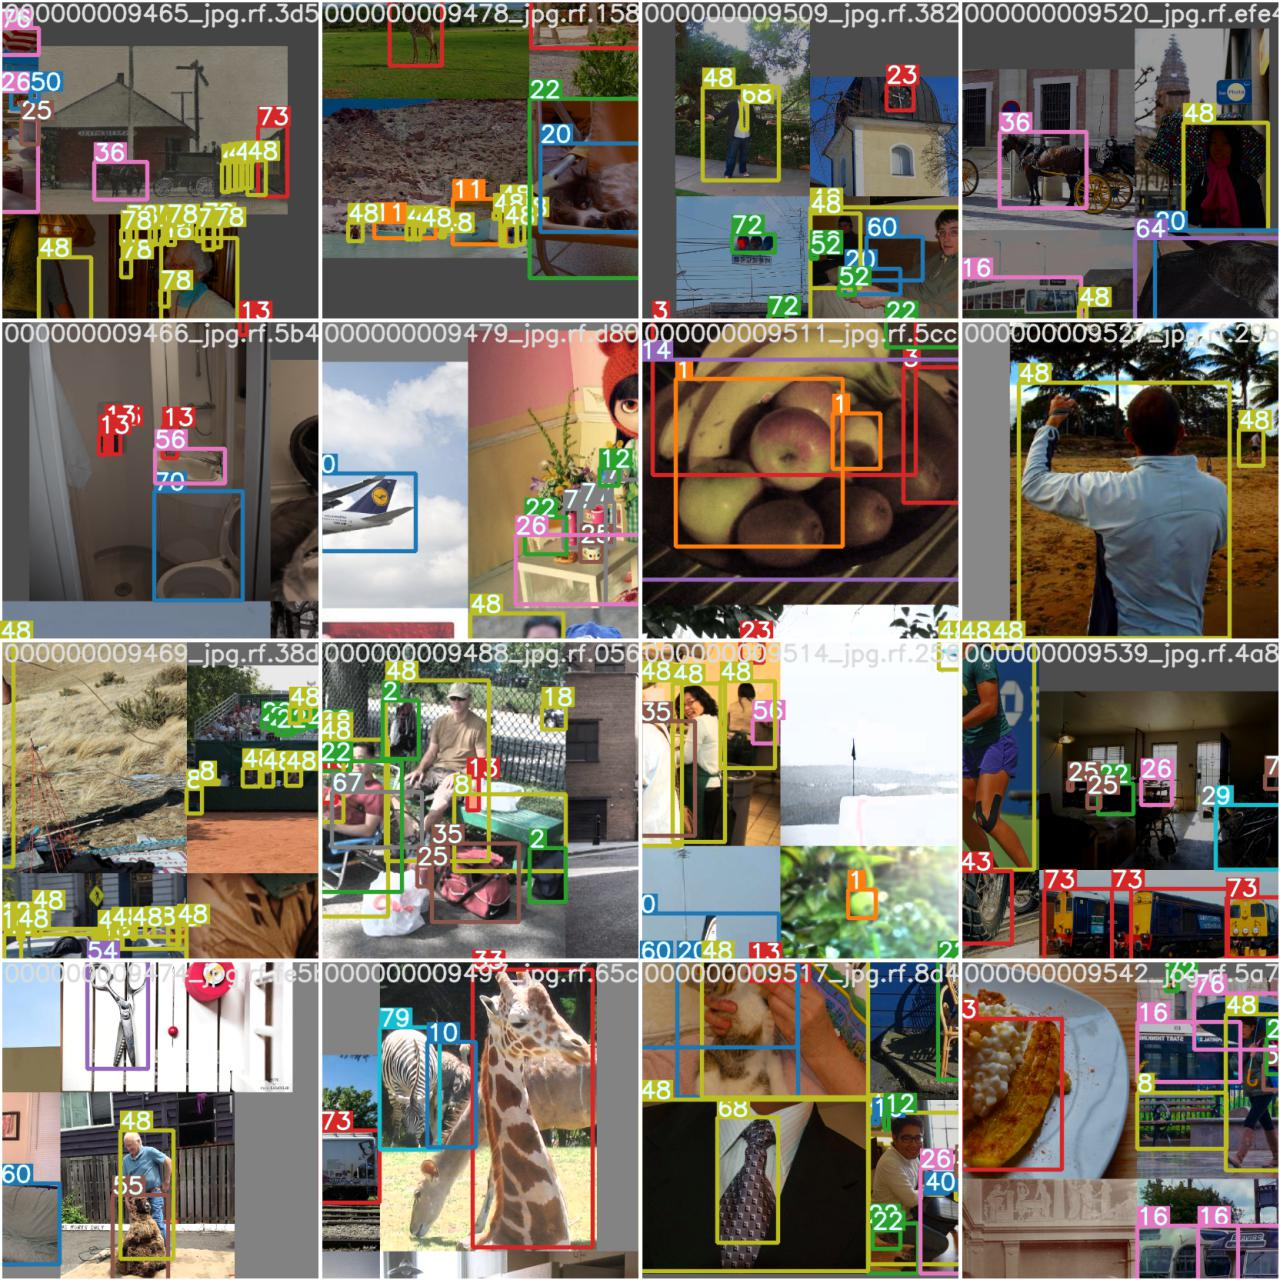

In [42]:
Image(filename='/workspace/notebook_yolov5_coco_final/yolov5/runs/train/yolov5m_results/train_batch0.jpg', width=600)

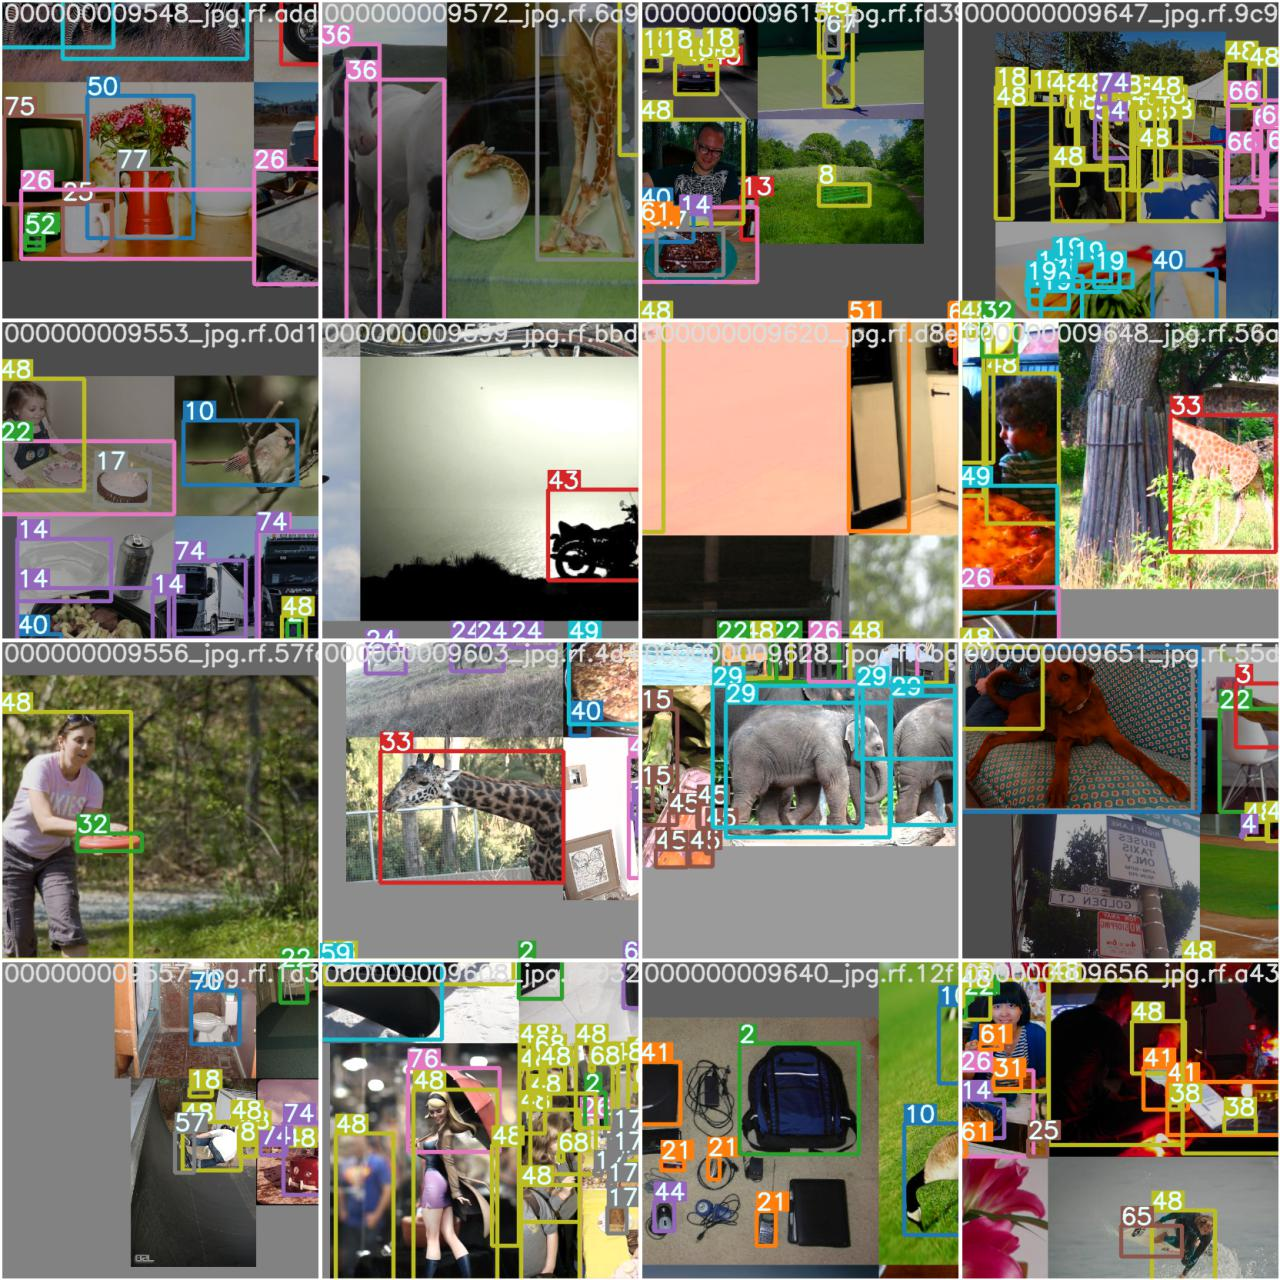

In [43]:
Image(filename='/workspace/notebook_yolov5_coco_final/yolov5/runs/train/yolov5m_results/train_batch1.jpg', width=600)

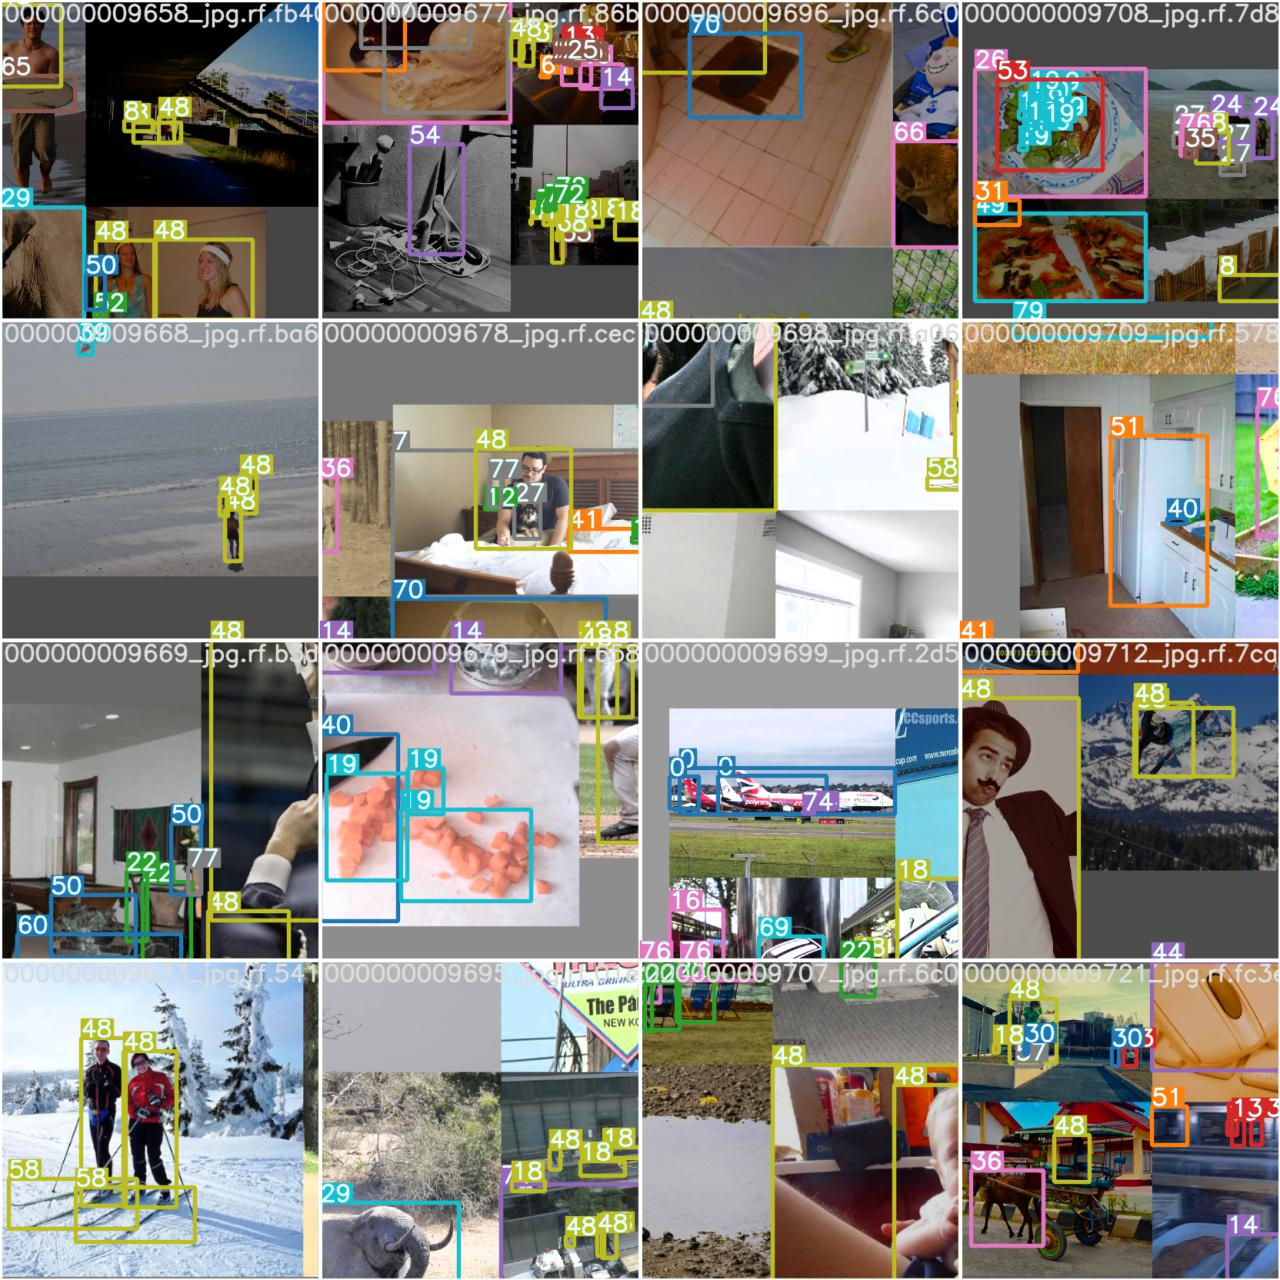

In [44]:
Image(filename='/workspace/notebook_yolov5_coco_final/yolov5/runs/train/yolov5m_results/train_batch2.jpg', width=600)

### Run YOLOv5 inference on test images

Perform inference on the contents of the data/images folder. You can add the images of your choice in the same folder in order to perform tests.

In [45]:
# trained weights are saved in the weights folder
%ls runs/train/yolov5m_results/weights

best.pt  last.pt


In [47]:
# use the best weights and print the test images list
%cd /workspace/notebook_yolov5_coco_final/yolov5/
!python detect.py --weights runs/train/yolov5m_results/weights/best.pt --img 416 --conf 0.4 --source data/images

/workspace/notebook_yolov5_coco_final/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images', update=False, view_img=False, weights=['runs/train/yolov5m_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.8.1 CUDA:0 (Tesla V100S-PCIE-32GB, 32510.5MB)
                                     CUDA:1 (Tesla V100S-PCIE-32GB, 32510.5MB)

Fusing layers... 
Model Summary: 308 layers, 21356877 parameters, 0 gradients, 51.3 GFLOPS
image 1/4 /workspace/notebook_yolov5_coco_final/yolov5/data/images/dog_street.jpg: 416x416 1 bicycle, 1 dog, 5 persons, Done. (0.019s)
image 2/4 /workspace/notebook_yolov5_coco_final/yolov5/data/images/keyboard_phone.jpg: 224x416 1 book, 1 cell phone, 1 cup, 1 laptop, 1 person, 1 pottedplant, Done. (0.025s)
image 3/4 /workspace/notebook_yolov5_coco_final/yolov5/data/images/lille_place.jpg: 256x

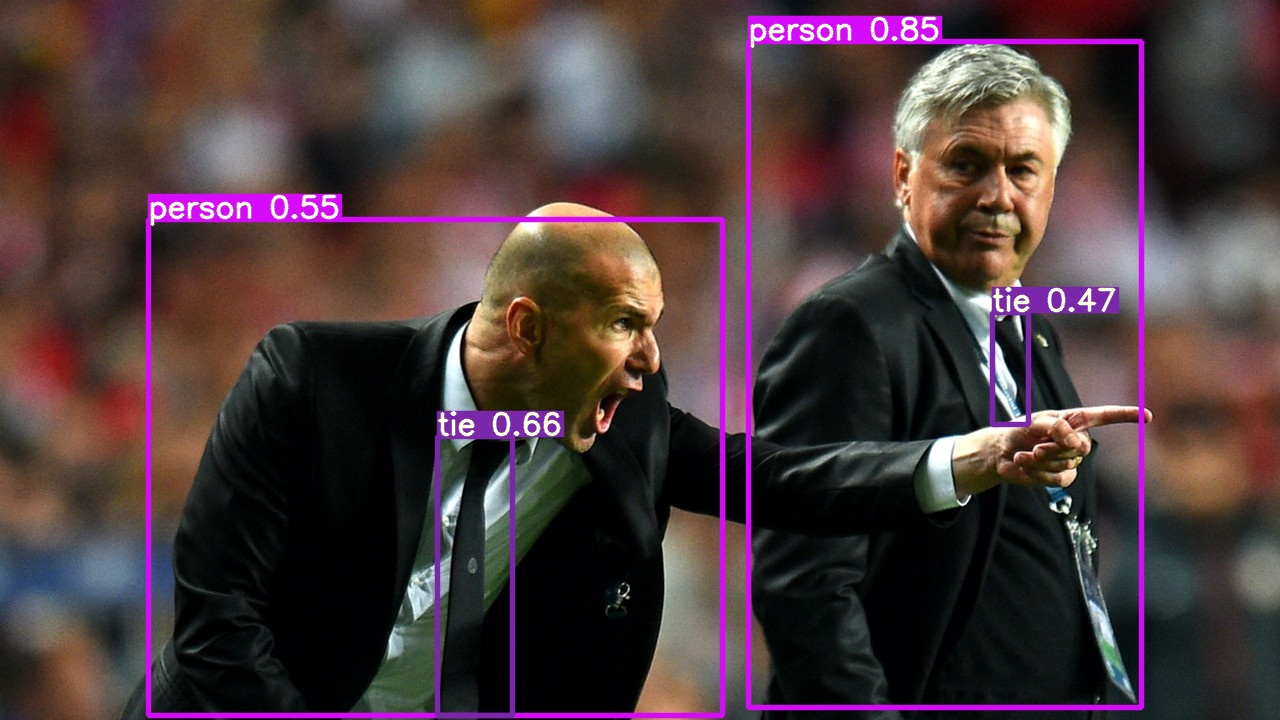

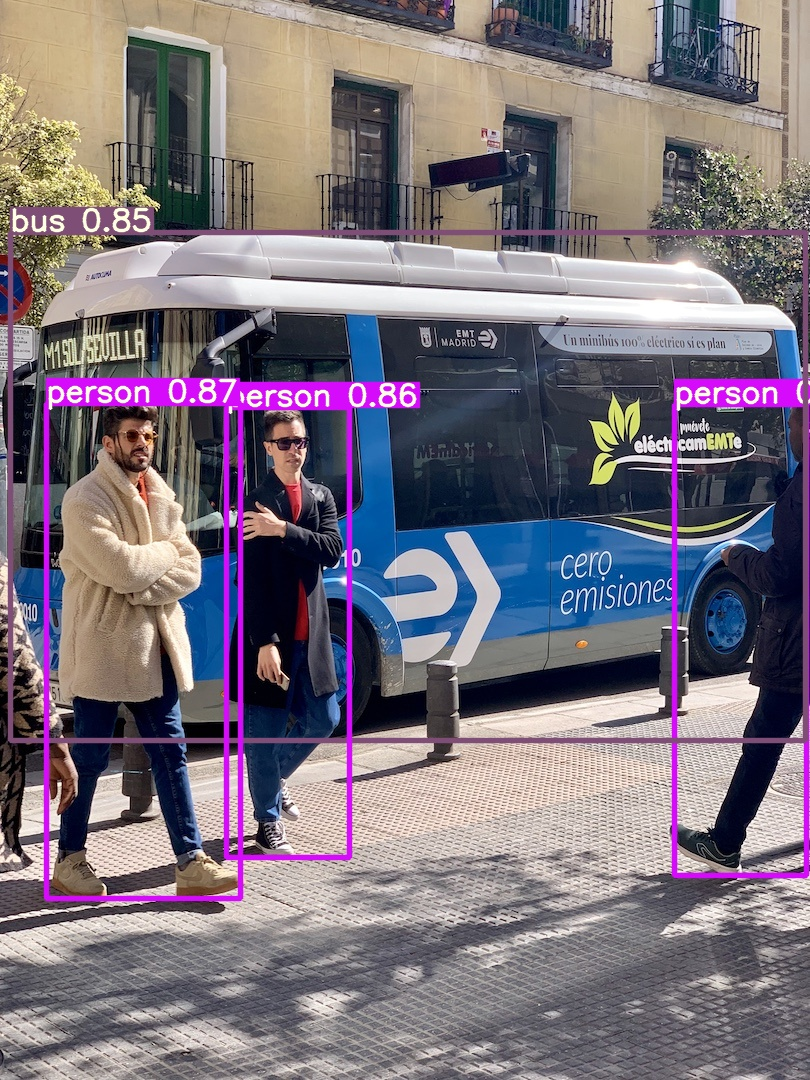

In [48]:
# display inference on all test images
# you can add some images in the folder named "data/images" to test your model
import glob
from IPython.display import Image, display

for imageName in glob.glob('/workspace/notebook_yolov5_coco_final/yolov5/runs/detect/exp/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

## Conclusion

The yolov5m model has been trained on 100 epochs for almost 20 hours with two GPUs. 

The performance results on the COCO database are as follows after 100 epochs:

**LOSS:**
- Box: 0.04925   
- Objectness: 0.05124   
- Clasification: 0.02172
- val Box: 0.04626   
- val Objectness: 0.03556   
- val Classification: 0.01736

**PRECISION & RECALL:**
- Precision: 0.6676     
- Recall: 0.496

**ACCURACY:**
- mAP @0.5: 0.531    
- mAP @0.5:0.95: 0.3463   

=> We note that the losses are relatively low. The accuracies can however be better although the image tests seem to return correct results.

**<font color='red'>How to improve results ?</font>**
- First, by increasing the number of epochs (with care of overfitting)
- Second, by changing the batch size

*N.B: If the performance of the yolov5m model does not change with these modifications, it is possible to change the model (yolov5 s/m/l/x).*